# Forecasting Video Game Sales

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder


In [172]:


input_file = "data\\Video_Games.csv"
output_file = "data\\fullyEncoded.csv"

def preprocess_data(df=None, null_limit=300, null_flag="tbd", platform_cutoff="WiiU", year_cutoff=1990.0,
              write_to_file=False, output="data\\fullyEncoded.csv", input="data\\Video_Games.csv"):
    
    # preview df
    if df is None:
        df = pd.read_csv(input)
        
    # keep name index for later
    name_index = dict(zip(df.Name, df.index))
    drop_cols = [
        "Name",                                                 # all unique / index
        "NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales",      # focus on global sales
        "Publisher", "Developer"                                # basically the same as platform; low PCA score
    ]
    df = df.drop(columns=drop_cols, axis=1)
    
    # initialize encoder
    encoder = LabelEncoder()
           
    # drop initial null values
    null_ct = df.isnull().sum()
    null_drop = null_ct[null_ct <= null_limit].index
    null_fill = null_ct.index.difference(null_drop)
    df = df.dropna(subset=null_drop)
    
    # cut off after set year
    df = df[df.Year_of_Release > year_cutoff]
      
    # cut off small/old platforms
    platforms = df.Platform.value_counts().keys()
    skip_platforms = ['SNES', 'SAT', 'GBA', 'GC']
    keep_platform = []
    for pl in platforms:
        if pl not in skip_platforms:
            keep_platform.append(pl)
        if pl == platform_cutoff:
            break
    # print(f"\nKeeping Platforms: {keep_platform}\n")
    df = df[df.Platform.isin(keep_platform)]

    # scale critic score so both user and critic scores are out of 10
    df["Critic_Score"] = df.Critic_Score.apply(lambda x: x/10)

    for col in null_fill:
        if df[col].dtype != "float64":
            # get indices with non-null values
            not_null = df[col].notna() 
             
            # replace null-flagged strings with null
            df.loc[df[col].values == null_flag, col] = None
            if col == "Platform":
                print(df[col].value_counts())
            # try to convert col to numeric, else use label encoder
            try:
                df.loc[not_null, col] = pd.to_numeric(df[col], errors="raise")
            except ValueError:
                df.loc[not_null, col] = encoder.fit_transform(df.loc[not_null, col])

        # fill in missing values with column median
        df.loc[df[col].isna(), col] = df[col].median(axis=0)
        
    for col in df.select_dtypes(exclude='float').columns:
        df.loc[:, col] = encoder.fit_transform(df.loc[:, col]).astype('float64')
    
    if write_to_file:
        _ = df.to_csv(output, index=False)
    
    return df, encoder, name_index


def scale_norm_scores(scores, rater_counts):
    weighted_score = scores*rater_counts
    n_evaluators = np.sum(rater_counts)

    norm_scores = np.zeros(scores.shape)
    scaled_norm_scores = np.zeros(norm_scores.shape)

    if n_evaluators != 0:
        # get weighted score
        norm_scores = weighted_score / n_evaluators
            
        # min-max norm to scale from 0-1
        min_val = np.min(norm_scores)
        max_val = np.max(norm_scores)

        if max_val - min_val != 0:
            # If max and min are the same, all values are identical
            scaled_norm_scores = (norm_scores-min_val) / (max_val-min_val)

    print(scaled_norm_scores.describe())
    return scaled_norm_scores


def heatmap(df):
    cmap='coolwarm'
    corrmat = df.corr()
    top_corr_features = corrmat.index

    #plot heat map
    plt.figure(figsize=(8,8))
    g = sns.heatmap(df[top_corr_features].corr(),
                annot=True,
                cmap=cmap) 
    plt.show()


<class 'pandas.core.frame.DataFrame'>
Index: 14259 entries, 0 to 16718
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Platform         14259 non-null  object 
 1   Year_of_Release  14259 non-null  float64
 2   Genre            14259 non-null  object 
 3   Global_Sales     14259 non-null  float64
 4   Critic_Score     14259 non-null  float64
 5   Critic_Count     14259 non-null  float64
 6   User_Score       14259 non-null  float64
 7   User_Count       14259 non-null  float64
 8   Rating           14259 non-null  object 
dtypes: float64(6), object(3)
memory usage: 1.1+ MB


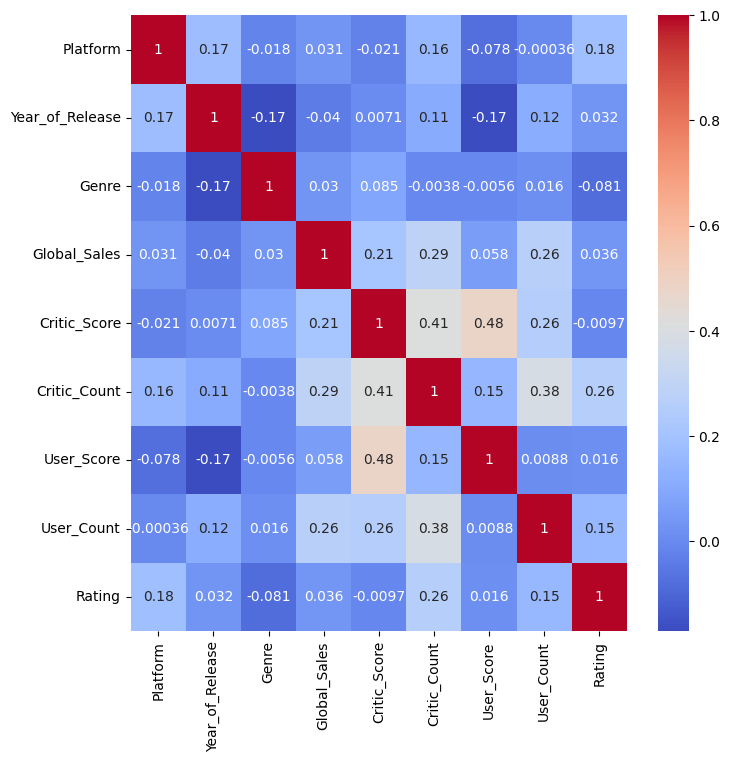

In [173]:

df, encoder, name_index = preprocess_data(write_to_file=True, output=output_file)

df.info()
heatmap(df)
